In [2]:
import sklearn
from sklearn.svm import OneClassSVM
import pennylane as qml
import numpy as np
import matplotlib.pyplot as plt
from utils import simple_train_test_split
import os

In [ ]:
from utils import simple_train_test_split
from sklearn.preprocessing import MaxAbsScaler

import os

# Define the noise level in ppm
noise_ppm = 0

# Import the exoplanet data:
path = f'data/processed_spectra/{noise_ppm}ppm'

In [24]:
## Load latent data

latent_data_path = f'regularized_autoencoder/{noise_ppm}ppm'

latent_normal_train_raw = np.load(os.path.join(latent_data_path, f'latent_normal_train_{noise_ppm}ppm.npy'))
latent_normal_test_raw = np.load(os.path.join(latent_data_path, f'latent_normal_test_{noise_ppm}ppm.npy'))
latent_anom_raw = np.load(os.path.join(latent_data_path, f'latent_anom_{noise_ppm}ppm.npy'))

# Print the shapes of the latent data
print('Loaded latent data:')
print(f"latent_normal_train_raw shape: {latent_normal_train_raw.shape}")
print(f"latent_normal_test_raw  shape: {latent_normal_test_raw.shape}")
print(f"latent_anom_raw         shape: {latent_anom_raw.shape}")

# # Make Plots:

# fig = plt.subplots(2,4,figsize=(10,5))
# plt.tight_layout()

# bins = np.linspace(-0.1, 0.1, 20)

# for i in range(8):
#     plt.subplot(2,4,i+1)
#     plt.hist(latent_normal_train_raw[:,i], bins=bins, alpha=0.5, label='normal')
#     plt.hist(latent_anom_raw[:,i], bins=bins, alpha=0.5, label='anomalous')
#     plt.legend()

# plt.suptitle(f'Latent space distribution for {noise_ppm} ppm noise', y=1.02)

Loaded latent data:
latent_normal_train_raw shape: (12303, 8)
latent_normal_test_raw  shape: (3076, 8)
latent_anom_raw         shape: (17869, 8)


### Scale the data feature-wise to [-1,1]

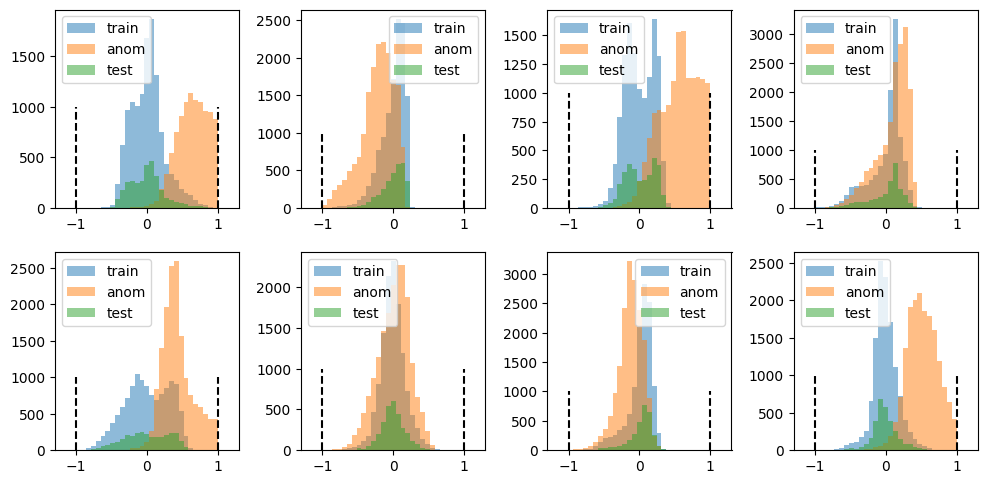

In [12]:
scaler = MaxAbsScaler()
x_train = scaler.fit_transform(latent_normal_train_raw)
x_test = scaler.transform(latent_normal_test_raw)
x_anom = scaler.transform(latent_anom_raw)


fig = plt.subplots(2,4,figsize=(10,5))
plt.tight_layout()

bins = np.linspace(-1, 1, 30)

for i in range(8):
    plt.subplot(2,4,i+1)
    plt.hist(x_train[:,i], bins=bins, alpha=0.5, label='train')
    plt.hist(x_anom[:,i], bins=bins, alpha=0.5, label='anom')
    plt.hist(x_test[:,i], bins=bins, alpha=0.5, label='test')
    plt.xlim(-1.3, 1.3)
    plt.vlines([-1, 1], 0, 1000, color='k', linestyle='--')
    plt.legend()

# Define all kernel circuits

In [25]:
nqubits = 4
dev = qml.device("lightning.qubit", wires=nqubits)

@qml.qnode(dev)
def amplitude_kernel_circ(a, b):
    qml.AmplitudeEmbedding(
        a, wires=range(nqubits), pad_with=0, normalize=True)
    qml.adjoint(qml.AmplitudeEmbedding(
        b, wires=range(nqubits), pad_with=0, normalize=True))
    return qml.probs(wires = range(nqubits))

    # Keep your custom kernel definition the same
def amplitude_kernel(A, B):
    return np.array([[amplitude_kernel_circ(a, b)[0] for b in B] for a in A])


dev = qml.device("lightning.qubit", wires=nqubits)
@qml.qnode(dev)
def angle_kernel_circ(a, b, n_qubits=8):
    qml.AngleEmbedding(a, wires=range(nqubits))
    qml.adjoint(qml.AngleEmbedding(b, wires=range(nqubits)))
    return qml.probs(wires = range(nqubits))

# Keep your custom kernel definition the same
def angle_qkernel(A, B):
    return np.array([[angle_kernel_circ(a, b)[0] for b in B] for a in A])

# Train the one-class SVM
amplitude_svm = OneClassSVM(kernel=amplitude_kernel).fit(x_train[:64])
angle_svm = OneClassSVM(kernel=angle_qkernel).fit(x_train_scaled[:64])

ValueError: Features must be of length 4 or less; got length 8.

In [ ]:


# Train the one-class SVM
svm = OneClassSVM(kernel=qkernel).fit(x_train[:64])

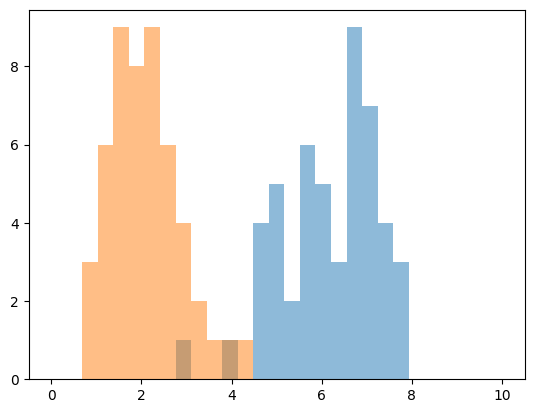

In [16]:
test_preds = svm.score_samples(x_test[:50])
anom_preds = svm.score_samples(x_anom[:50])

bins = np.linspace(0, 10, 30)
plt.hist(test_preds, bins=bins, alpha=0.5, label='test')
plt.hist(anom_preds, bins=bins, alpha=0.5, label='anom')
plt.show()

In [18]:
# Keep your custom kernel definition the same
def qkernel(A, B):
    return np.array([[kernel_circ(a, b)[0] for b in B] for a in A])

# Train the one-class SVM
svm = OneClassSVM(kernel=qkernel).fit(x_train_scaled[:64])

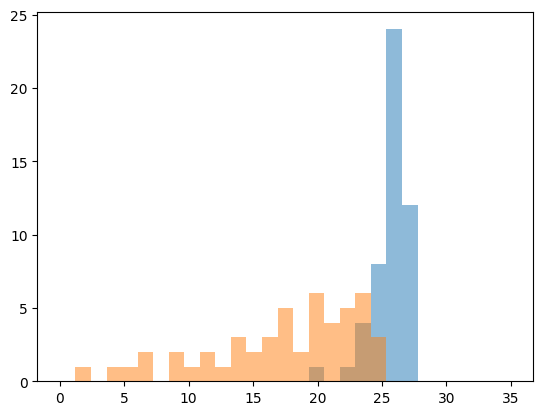

In [19]:
test_preds = svm.score_samples(x_test_scaled[:50])
anom_preds = svm.score_samples(x_anom_scaled[:50])

bins = np.linspace(0, 35, 30)
plt.hist(test_preds, bins=bins, alpha=0.5, label='test')
plt.hist(anom_preds, bins=bins, alpha=0.5, label='anom')
plt.show()

In [20]:
from itertools import combinations

def ZZFeatureMap(nqubits, data):

    # Number of variables that we will load:
    # could be smaller than the number of qubits.
    nload = min(len(data), nqubits)

    for i in range(nload):
        qml.Hadamard(i)
        qml.RZ(2.0 * data[i], wires = i)

    for pair in list(combinations(range(nload), 2)):
        q0 = pair[0]
        q1 = pair[1]

        qml.CZ(wires = [q0, q1])
        qml.RZ(2.0 * (np.pi - data[q0]) *
            (np.pi - data[q1]), wires = q1)
        qml.CZ(wires = [q0, q1])

In [21]:
nqubits = 4
dev = qml.device("lightning.qubit", wires = nqubits)

@qml.qnode(dev)
def kernel_circ(a, b):
    ZZFeatureMap(nqubits, a)
    qml.adjoint(ZZFeatureMap)(nqubits, b)
    return qml.probs(wires = range(nqubits))

In [22]:
# Train the one-class SVM
svm = OneClassSVM(kernel=qkernel).fit(x_train_scaled[:64])

(array([0., 4., 1., 4., 3., 4., 2., 1., 3., 4., 3., 4., 1., 3., 2., 0., 1.,
        3., 1., 1., 2., 0., 2., 0., 1., 0., 0., 0., 0.]),
 array([0.        , 0.17241379, 0.34482759, 0.51724138, 0.68965517,
        0.86206897, 1.03448276, 1.20689655, 1.37931034, 1.55172414,
        1.72413793, 1.89655172, 2.06896552, 2.24137931, 2.4137931 ,
        2.5862069 , 2.75862069, 2.93103448, 3.10344828, 3.27586207,
        3.44827586, 3.62068966, 3.79310345, 3.96551724, 4.13793103,
        4.31034483, 4.48275862, 4.65517241, 4.82758621, 5.        ]),
 <BarContainer object of 29 artists>)

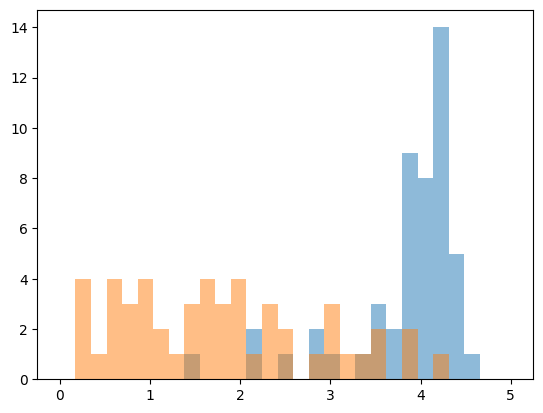

In [38]:
test_preds = svm.score_samples(x_test_scaled[:50])
anom_preds = svm.score_samples(x_anom_scaled[:50])

bins = np.linspace(0, 5, 30)
plt.hist(test_preds, bins=bins, alpha=0.5, label='test')
plt.hist(anom_preds, bins=bins, alpha=0.5, label='anom')

In [42]:
def draw_hists(normal_scores, anom_scores, title, n_bins=30, vmin=None, vmax=None, draw_legend=True):
    if vmin is None:
        vmin = min(np.min(normal_scores), np.min(anom_scores))
    if vmax is None:
        vmax = max(np.max(normal_scores), np.max(anom_scores))
    bins = np.linspace(vmin, vmax, n_bins)
    plt.hist(normal_scores, bins=bins, alpha=0.5, label='Normal')
    plt.hist(anom_scores, bins=bins, alpha=0.5, label='Anom')
    plt.title(title)
    if draw_legend: plt.legend()
    plt.show()

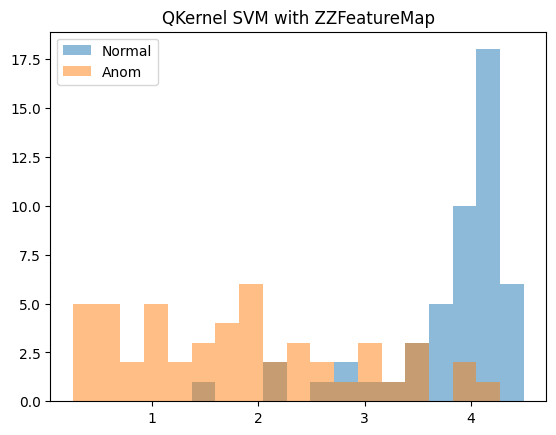

In [44]:
draw_hists(test_preds, anom_preds, 'QKernel SVM with ZZFeatureMap', 20)
# Save the model